#### Construct mini dataset
> - 10,000 Notes, 50 Songs, 100-900 Notes per Song
> - Solo Piano, Solo Cello, Solo Violin, and Solo Flute pieces
> - Downsampled songs, notes samples, and notes labels constructed in /data/mini/

#### Setup
***

In [56]:
import os
curr_dir = os.getcwd()
base_dir = os.path.dirname(curr_dir)
# Base directory: /project-noteGen
# Current directory: /core  

import numpy as np
import csv
import pandas as pd
import librosa
from scipy.io.wavfile import read as read_wav
from scipy.io.wavfile import write as write_wav
import matplotlib.pyplot as plt
import copy
import shutil
import pickle

import preprocess
import visualize

######
#### Select songs (50)
***

In [57]:
all_songs = pd.read_csv(f"{base_dir}/data/songs_metadata.csv").to_numpy()
#all_songs.shape

In [58]:
# Select 26 piano pieces, 12 cello pieces, 9 violin pieces, and 3 flute pieces
# (Dataset has 156 piano solos, 12 cell solos, 9 violin solos, and 3 flute solos)

solo_songs = np.array([song for song in all_songs if 'Solo' in song[4]])
#print(solo_songs.shape)

solo_pianos = np.array([song[0] for song in all_songs if 'Solo Piano' in song[4]])
solo_cellos = np.array([song[0] for song in all_songs if 'Solo Cello' in song[4]])
solo_violins = np.array([song[0] for song in all_songs if 'Solo Violin' in song[4]])
solo_flutes = np.array([song[0] for song in all_songs if 'Solo Flute' in song[4]])

#print(solo_pianos.shape)
#print(solo_cellos.shape)
#print(solo_violins.shape)
#print(solo_flutes.shape)

np.random.seed(2)

piano_solos = np.random.choice(solo_pianos, 26, replace=False)
cello_solos = np.random.choice(solo_cellos, 12, replace=False)
violin_solos = np.random.choice(solo_violins, 9, replace=False)
flute_solos = np.random.choice(solo_flutes, 3, replace=False)

In [59]:
# Downsample 50 pieces at 22050 kHz, and store in data/mini/songs/
# Store associated labels in data/mini/songs/full_labels

mini_songs = np.concatenate([piano_solos, cello_solos, violin_solos, flute_solos])
train_songs = [song.replace('.wav', '') for song in os.listdir(f"{base_dir}/data/raw/train_data")]
test_songs = [song.replace('.wav', '') for song in os.listdir(f"{base_dir}/data/raw/test_data")]

"""
for song in mini_songs:
    if str(song) in train_songs:
        tag = "train"
    elif str(song) in test_songs:
        tag = "test"
    else:
        raise Exception("Song id not found.")
        
    sourcepath = f"{base_dir}/data/raw/{tag}_data/{song}.wav"
    destpath = f"{base_dir}/data/mini/songs/{song}_x2.wav"
    _ = preprocess.downsample_wav(sourcepath, destpath, rate=22050)
    
    shutil.copy(f"{base_dir}/data/raw/{tag}_labels/{song}.csv", f"{base_dir}/data/mini/full_labels/{song}.csv")
"""

'\nfor song in mini_songs:\n    if str(song) in train_songs:\n        tag = "train"\n    elif str(song) in test_songs:\n        tag = "test"\n    else:\n        raise Exception("Song id not found.")\n        \n    sourcepath = f"{base_dir}/data/raw/{tag}_data/{song}.wav"\n    destpath = f"{base_dir}/data/mini/songs/{song}_x2.wav"\n    _ = preprocess.downsample_wav(sourcepath, destpath, rate=22050)\n    \n    shutil.copy(f"{base_dir}/data/raw/{tag}_labels/{song}.csv", f"{base_dir}/data/mini/full_labels/{song}.csv")\n'

In [60]:
songs = os.listdir(f"{base_dir}/data/mini/songs")
labels = os.listdir(f"{base_dir}/data/mini/full_labels")
print(len(songs))
print(len(labels))

50
51


In [61]:
songs = preprocess.get_folder_size(f"{base_dir}/data/mini/songs/")
labels = preprocess.get_folder_size(f"{base_dir}/data/mini/full_labels/")
print(f"Songs: {songs:7.3f} GB")
print(f"Labels: {labels:6.3f} GB")

Songs:   1.169 GB
Labels:  0.004 GB


######
#### Extract notes (10,000)
***

In [62]:
# Single note object
class note:
    """
    Fields:
        song_id: source song's id
        note_id: note's id within song
        samples: list of samples for the note
    """
    def __init__(self, song_id, note_id, samples):
        self.song_id = song_id
        self.note_id = note_id
        self.samples = samples

In [63]:
# Construct note samples for all 50 songs
piano_solos_song_notes = []
cello_solos_song_notes = []
violin_solos_song_notes = []
flute_solos_song_notes = []
mini_ids = [song.replace('_x2.wav', '') for song in os.listdir(f"{base_dir}/data/mini/songs")]
for mini_id in mini_ids:
    source = read_wav(f"{base_dir}/data/mini/songs/{mini_id}_x2.wav")
    labels = pd.read_csv(f"{base_dir}/data/mini/full_labels/{mini_id}.csv").to_numpy()
    assert source[0] == 22050
    note_samples = preprocess.construct_note_samples(source, labels, ds_rate=22050)
    song_notes = [note(song_id=int(mini_id), note_id=i, samples=note_i_samples) for i, note_i_samples in enumerate(note_samples)]
    
    if int(mini_id) in piano_solos:
        piano_solos_song_notes.append(song_notes)
    elif int(mini_id) in cello_solos:
        cello_solos_song_notes.append(song_notes)
    elif int(mini_id) in violin_solos:
        violin_solos_song_notes.append(song_notes)
    elif int(mini_id) in flute_solos:
        flute_solos_song_notes.append(song_notes)
    else:
        raise Exception(f"Song {mini_id} not associated with a solo")
assert len(cello_solos_song_notes) == 12

In [64]:
# Divide 10,000 notes (3200 piano notes, 2400 cello notes, 2400 violin notes, 2000 flute notes) across 50 songs
notes_per_piano_solo = np.array([list_of_notes.size for list_of_notes in np.array_split(np.arange(1, 3201), 26)])
notes_per_cello_solo = np.array([list_of_notes.size for list_of_notes in np.array_split(np.arange(1, 2401), 12)])
notes_per_violin_solo = np.array([list_of_notes.size for list_of_notes in np.array_split(np.arange(1, 2401), 9)])
notes_per_flute_solo = np.array([list_of_notes.size for list_of_notes in np.array_split(np.arange(1, 2001), 3)])
assert notes_per_piano_solo.size + notes_per_cello_solo.size + notes_per_violin_solo.size + notes_per_flute_solo.size == 50
assert np.sum(np.concatenate([notes_per_piano_solo, notes_per_cello_solo, notes_per_violin_solo, notes_per_flute_solo])) == 10000

In [65]:
# Select those notes from each song
np.random.seed(2)

mini_notes = []
for i, song_notes in enumerate(piano_solos_song_notes):
    try:
        selected_notes = np.random.choice(song_notes, notes_per_piano_solo[i], replace=False)
    except ValueError:
        print("Error: Number of selections from piano solo exceed number of notes in solo.")
        break
    mini_notes.extend(selected_notes)

for i, song_notes in enumerate(cello_solos_song_notes):
    try:
        selected_notes = np.random.choice(song_notes, notes_per_cello_solo[i], replace=False)
    except ValueError:
        print("Error: Number of selections from cello solo exceed number of notes in solo.")
        break
    mini_notes.extend(selected_notes)

for i, song_notes in enumerate(violin_solos_song_notes):
    try:
        selected_notes = np.random.choice(song_notes, notes_per_violin_solo[i], replace=False)
    except ValueError:
        print("Error: Number of selections from violin solo exceed number of notes in solo.")
        break
    mini_notes.extend(selected_notes)


for i, song_notes in enumerate(flute_solos_song_notes):
    try:
        selected_notes = np.random.choice(song_notes, notes_per_flute_solo[i], replace=False)
    except ValueError:
        #print("Error: Number of selections from flute solo exceed number of notes in solo.")
        break
    #mini_notes.extend(selected_notes)

# Round-robin notes across flute solos
song_i = 0
notes_across_flute_solos = np.sum(notes_per_flute_solo)
flute_solos_song_notes_copy = copy.deepcopy(flute_solos_song_notes)
flute_note_selections = [[] for i in range(len(flute_solos_song_notes))]

while notes_across_flute_solos > 0:
    if len(flute_solos_song_notes_copy[song_i]) > 0:
        selected_note = np.random.choice(flute_solos_song_notes_copy[song_i], 1, replace=False)
        flute_note_selections[song_i].extend(selected_note)
        flute_solos_song_notes_copy[song_i].remove(selected_note)
        notes_across_flute_solos -= 1
    song_i = 0 if song_i + 1 == len(flute_solos_song_notes_copy) else song_i + 1

for selected_notes in flute_note_selections:
    mini_notes.extend(selected_notes)
    
assert(len(mini_notes) == 10000)

In [66]:
# Verify notes are extracted correctly (30s)

for i in range(10000):
    song_id = mini_notes[i].song_id
    note_id = mini_notes[i].note_id
    samples = mini_notes[i].samples
    labels = pd.read_csv(f"{base_dir}/data/mini/full_labels/{song_id}.csv").to_numpy()
    assert abs(len(samples) - (labels[note_id, 1] - labels[note_id, 0]) / 2) <= 1

unique_songs = []
unique_notes = []

for i in range(10000):
    song_id = mini_notes[i].song_id
    note_id = mini_notes[i].note_id
    if song_id not in unique_songs:
        unique_songs.append(song_id)
    if (song_id, note_id) not in unique_notes:
        unique_notes.append((song_id, note_id))

print(len(unique_songs))
print(len(unique_notes))

50
10000


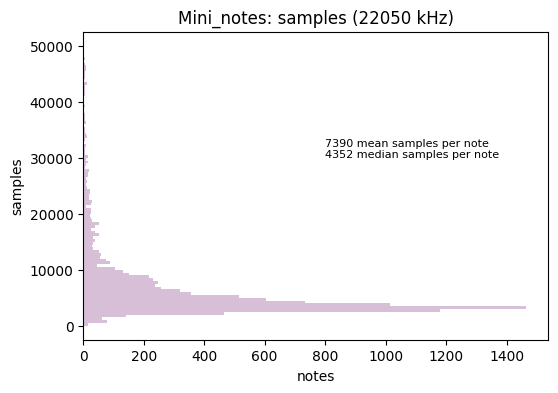

In [67]:
# Visualize length of notes

lengths = np.empty(10000)

for i in range(10000):
    lengths[i] = len(mini_notes[i].samples)

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(lengths, bins=100, range=(0, 50000), orientation='horizontal', color='thistle')
ax.set(xlabel='notes', ylabel='samples', title='Mini_notes: samples (22050 kHz)')
ax.text(800, 30000, f'{np.mean(lengths):.0f} mean samples per note\n'
                   f'{np.median(lengths):.0f} median samples per note', fontsize=8)
plt.show()

#with open(f"{base_dir}/data/general/update_lengths", "wb") as fobj:
    #pickle.dump(lengths, fobj)

######
#### Construct mini datasets (original, padded, scaled)
>- Original: Unchanged from actual timestep length
>- Padded: Centering over 8000 timestep window, 0 padding before and after
>- Scaled: Centering over 8000 timestep window, 0-1 scaling before and 1-0 scaling after
***

In [68]:
# Construct labels for original notes and centered notes in data/mini/note_labels

id_to_label = {}
for song_file in os.listdir(f"{base_dir}/data/mini/songs/"):
    song_id = int(song_file.replace('_x2.wav', ''))
    id_to_label[song_id] = pd.read_csv(f"{base_dir}/data/mini/full_labels/{song_id}.csv").to_numpy()

note_columns = ['source_song_id', 'note_from_song', 'start_time', 'end_time', 'instrument', 'key', 'start_beat', 'end_beat', 'note_value']
labels_original = pd.DataFrame(columns=note_columns)
labels_centered = pd.DataFrame(columns=note_columns)

for mini_note in mini_notes:
    song_id = mini_note.song_id
    note_id = mini_note.note_id
    
    label = id_to_label[song_id][note_id]
    original_label = np.concatenate(([song_id, note_id], label))
    labels_original.loc[len(labels_original)] = original_label
    
    note_length = label[1] - label[0]
    window_start = label[0]
    window_end = label[1]
    
    if note_length < 16000:
        extension = 16000 - note_length
        sub_extension = np.array_split(np.arange(extension), 2)
        window_start = label[0] - sub_extension[1].size
        window_end = label[1] + sub_extension[0].size
    elif note_length > 16000:
        trimming = note_length - 16000
        sub_trimming = np.array_split(np.arange(trimming), 2)
        window_start = label[0] + sub_trimming[1].size
        window_end = label[1] - sub_trimming[0].size
    
    assert window_end - window_start == 16000
    assert window_start >= 0
    
    centered_label = np.concatenate(([song_id, note_id], label))
    centered_label[2] = window_start
    centered_label[3] = window_end
    labels_centered.loc[len(labels_centered)] = centered_label

#labels_original.to_csv(f"{base_dir}/data/mini/note_labels/labels_original.csv", index=False)
#labels_centered.to_csv(f"{base_dir}/data/mini/note_labels/labels_centered.csv", index=False)

print('complete')

complete


In [69]:
test = pd.read_csv(f"{base_dir}/data/mini/note_labels/labels_original.csv").to_numpy()
print(test.shape)
print(f"piano notes: {test[:, 4][test[:, 4] == 1].size}")
print(f"cello notes: {test[:, 4][test[:, 4] == 43].size}")
print(f"violin notes: {test[:, 4][test[:, 4] == 41].size}")
print(f"viola notes: {test[:, 4][test[:, 4] == 42].size}")
print(f"flute notes: {test[:, 4][test[:, 4] == 74].size}")
print()
ps = 0
cs = 0
vs = 0
fs = 0
for note in test:
    if note[0] in piano_solos: ps += 1
    elif note[0] in cello_solos: cs += 1
    elif note[0] in violin_solos: vs += 1
    elif note[0] in flute_solos: fs += 1
    else: raise Exception
print(f"from piano solos: {ps}")
print(f"from cello solos: {cs}")
print(f"from violin solos: {vs}")
print(f"from flute solos: {fs}")
mismatches = []
for note in test:
    if (note[0] in piano_solos and note[4] != 1) or (note[0] in cello_solos and note[4] != 43) \
        or (note[0] in violin_solos and note[4] != 41) or (note[0] in flute_solos and note[4] != 74):
        mismatches.append((note[0], note[1]))
# 4 "violin solos" contain multi-instrument notes, but there is still far less overlap than non-solo pieces

(10000, 9)
piano notes: 3200
cello notes: 2533
violin notes: 2077
viola notes: 190
flute notes: 2000

from piano solos: 3200
from cello solos: 2400
from violin solos: 2400
from flute solos: 2000


In [70]:
# Construct note samples for original, padded, and scaled notes in data/mini/note_samples

id_to_source = {}
for song_file in os.listdir(f"{base_dir}/data/mini/songs/"):
    song_id = int(song_file.replace('_x2.wav', ''))
    id_to_source[song_id] = read_wav(f"{base_dir}/data/mini/songs/{song_file}")[1]
labels_original = pd.read_csv(f"{base_dir}/data/mini/note_labels/labels_original.csv").to_numpy()
labels_centered = pd.read_csv(f"{base_dir}/data/mini/note_labels/labels_centered.csv").to_numpy()
    
time_factor = 22050 / 44100

notes_original = [[] for i in range(10000)] 
notes_padded = np.empty((10000, 8000))
notes_scaled = np.empty((10000, 8000))

for i, mini_note in enumerate(mini_notes):
    song_id = mini_note.song_id
    note_id = mini_note.note_id
    source = id_to_source[song_id]
    
    label_original = labels_original[i] 
    original_start = int(label_original[2] * time_factor)
    original_end = int(label_original[3] * time_factor)
    note_original = source[original_start:original_end]
    assert np.array_equal(mini_note.samples, note_original)
    notes_original[i] = note_original
    
    label_centered = labels_centered[i]
    window_start = int(label_centered[2] * time_factor)
    window_end = int(label_centered[3] * time_factor)
    window_size = window_end - window_start
    original_length = original_end - original_start
    
    if original_length > window_size:
        note_padded = source[window_start:window_end]
        note_scaled = source[window_start:window_end]
        
    elif original_length < window_size:
        inner_start = original_start - window_start
        inner_end = original_end - window_start
        
        note_padded = source[window_start:window_end].copy()
        note_padded[:inner_start] = 0
        note_padded[inner_end:] = 0
        assert np.array_equal(mini_note.samples, note_padded[inner_start:inner_end])
        
        note_scaled = source[window_start:window_end].copy()
        front_scaling = np.linspace(0, 1, original_start - window_start)**2
        tail_scaling = np.linspace(1, 0, window_end - original_end)**2
        note_scaled[:inner_start] *= front_scaling
        note_scaled[inner_end:] *= tail_scaling
        assert np.array_equal(mini_note.samples, note_scaled[inner_start:inner_end])
    else:
        raise Exception("Verify labels")
        
    notes_padded[i] = note_padded
    notes_scaled[i] = note_scaled

notes_original = np.array(notes_original, dtype=object)

# np.save(f"{base_dir}/data/mini/note_samples/notes_original.npy", notes_original)
# np.save(f"{base_dir}/data/mini/note_samples/notes_padded.npy", notes_padded)
# np.save(f"{base_dir}/data/mini/note_samples/notes_scaled.npy", notes_scaled)
print("done")

done


In [71]:
notes_size = preprocess.get_folder_size(f"{base_dir}/data/mini/note_samples/")
labels_size = preprocess.get_folder_size(f"{base_dir}/data/mini/note_labels/")
print(f"notes: {notes_size:7.4} GB")
print(f"labels: {labels_size:7.2} GB")

notes:   1.576 GB
labels:  0.0011 GB


######
#### Compare mini dataset variations

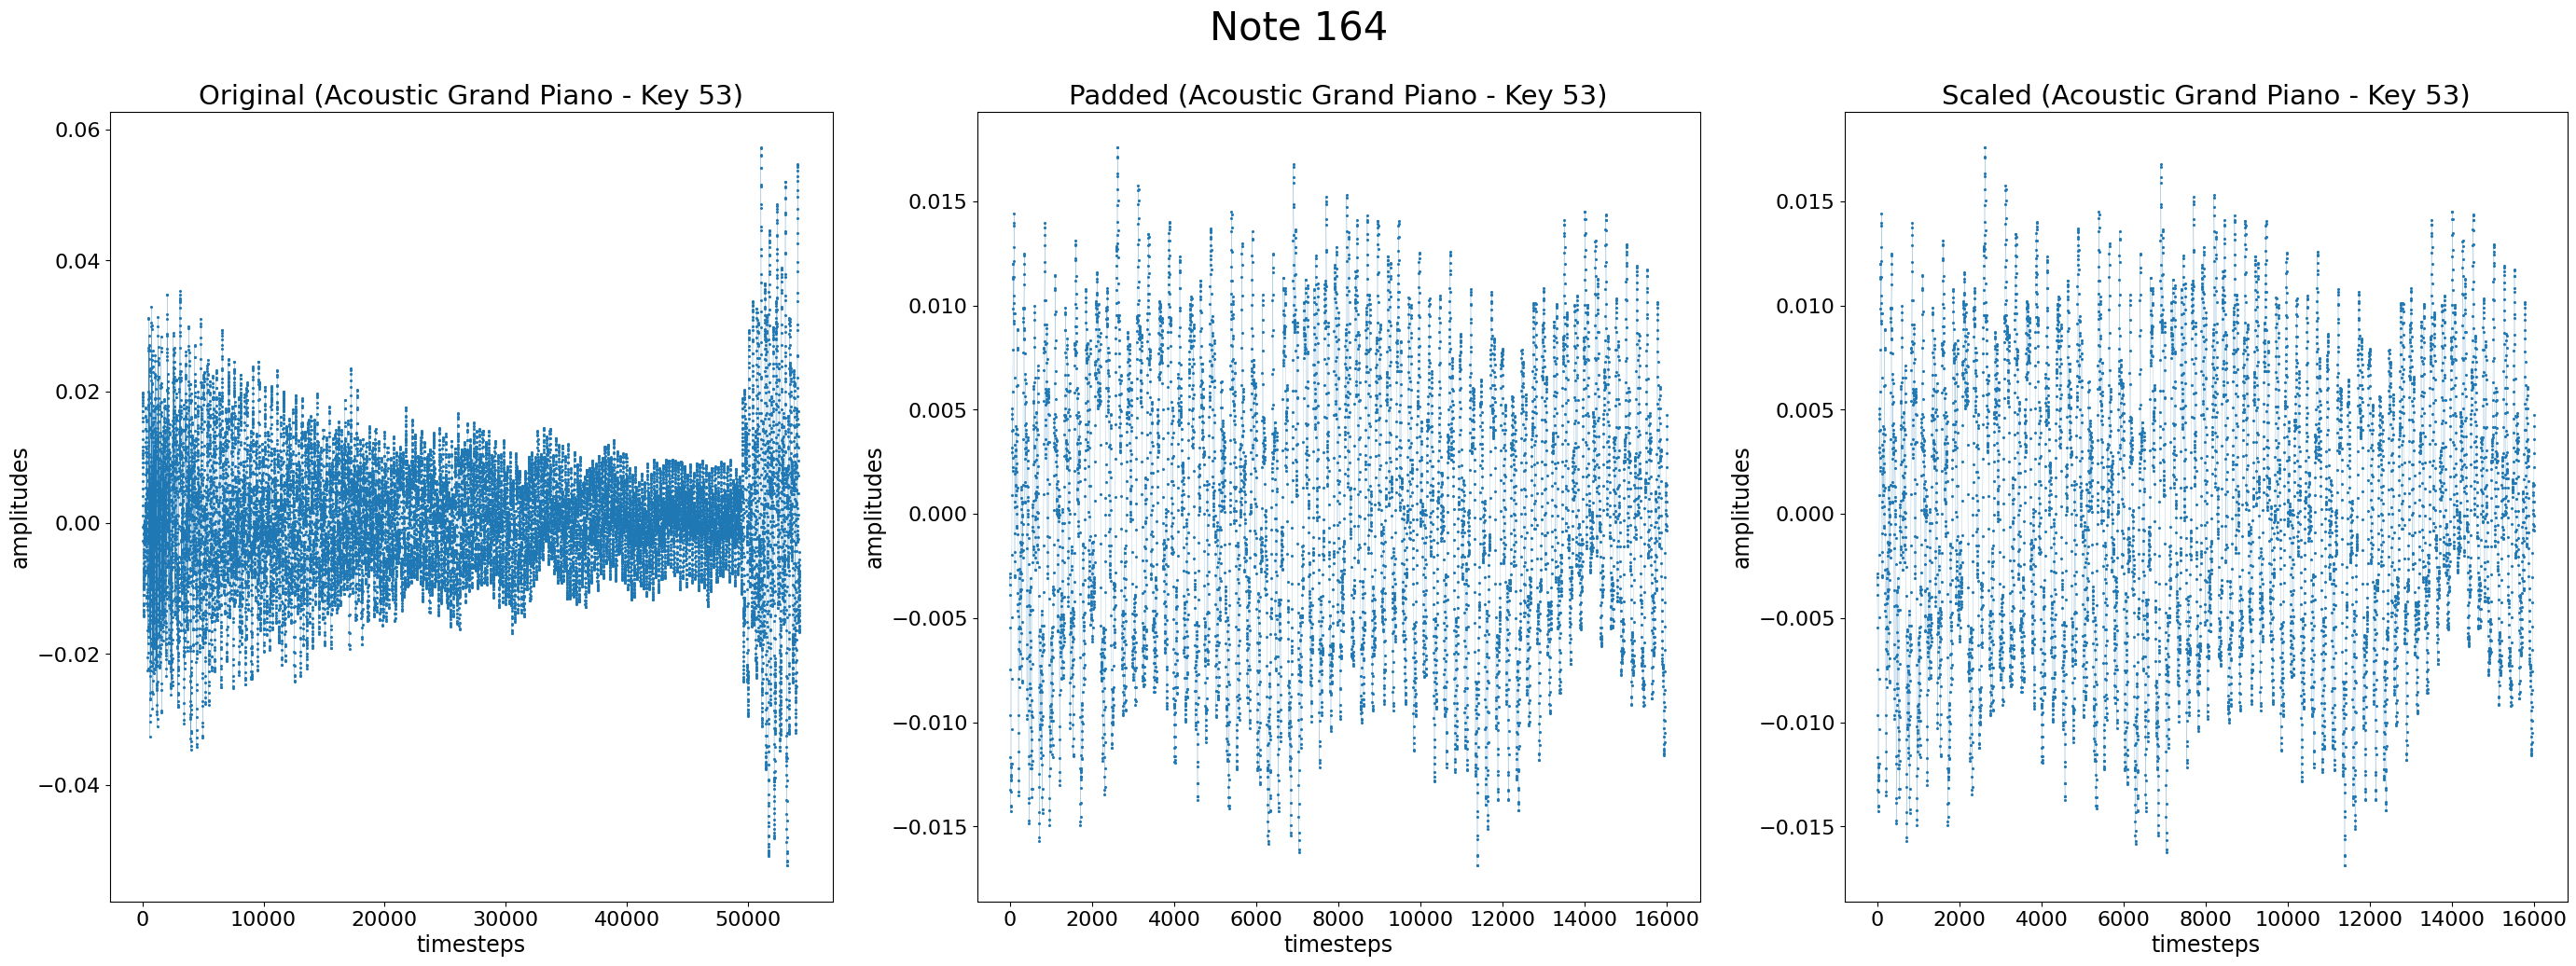

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

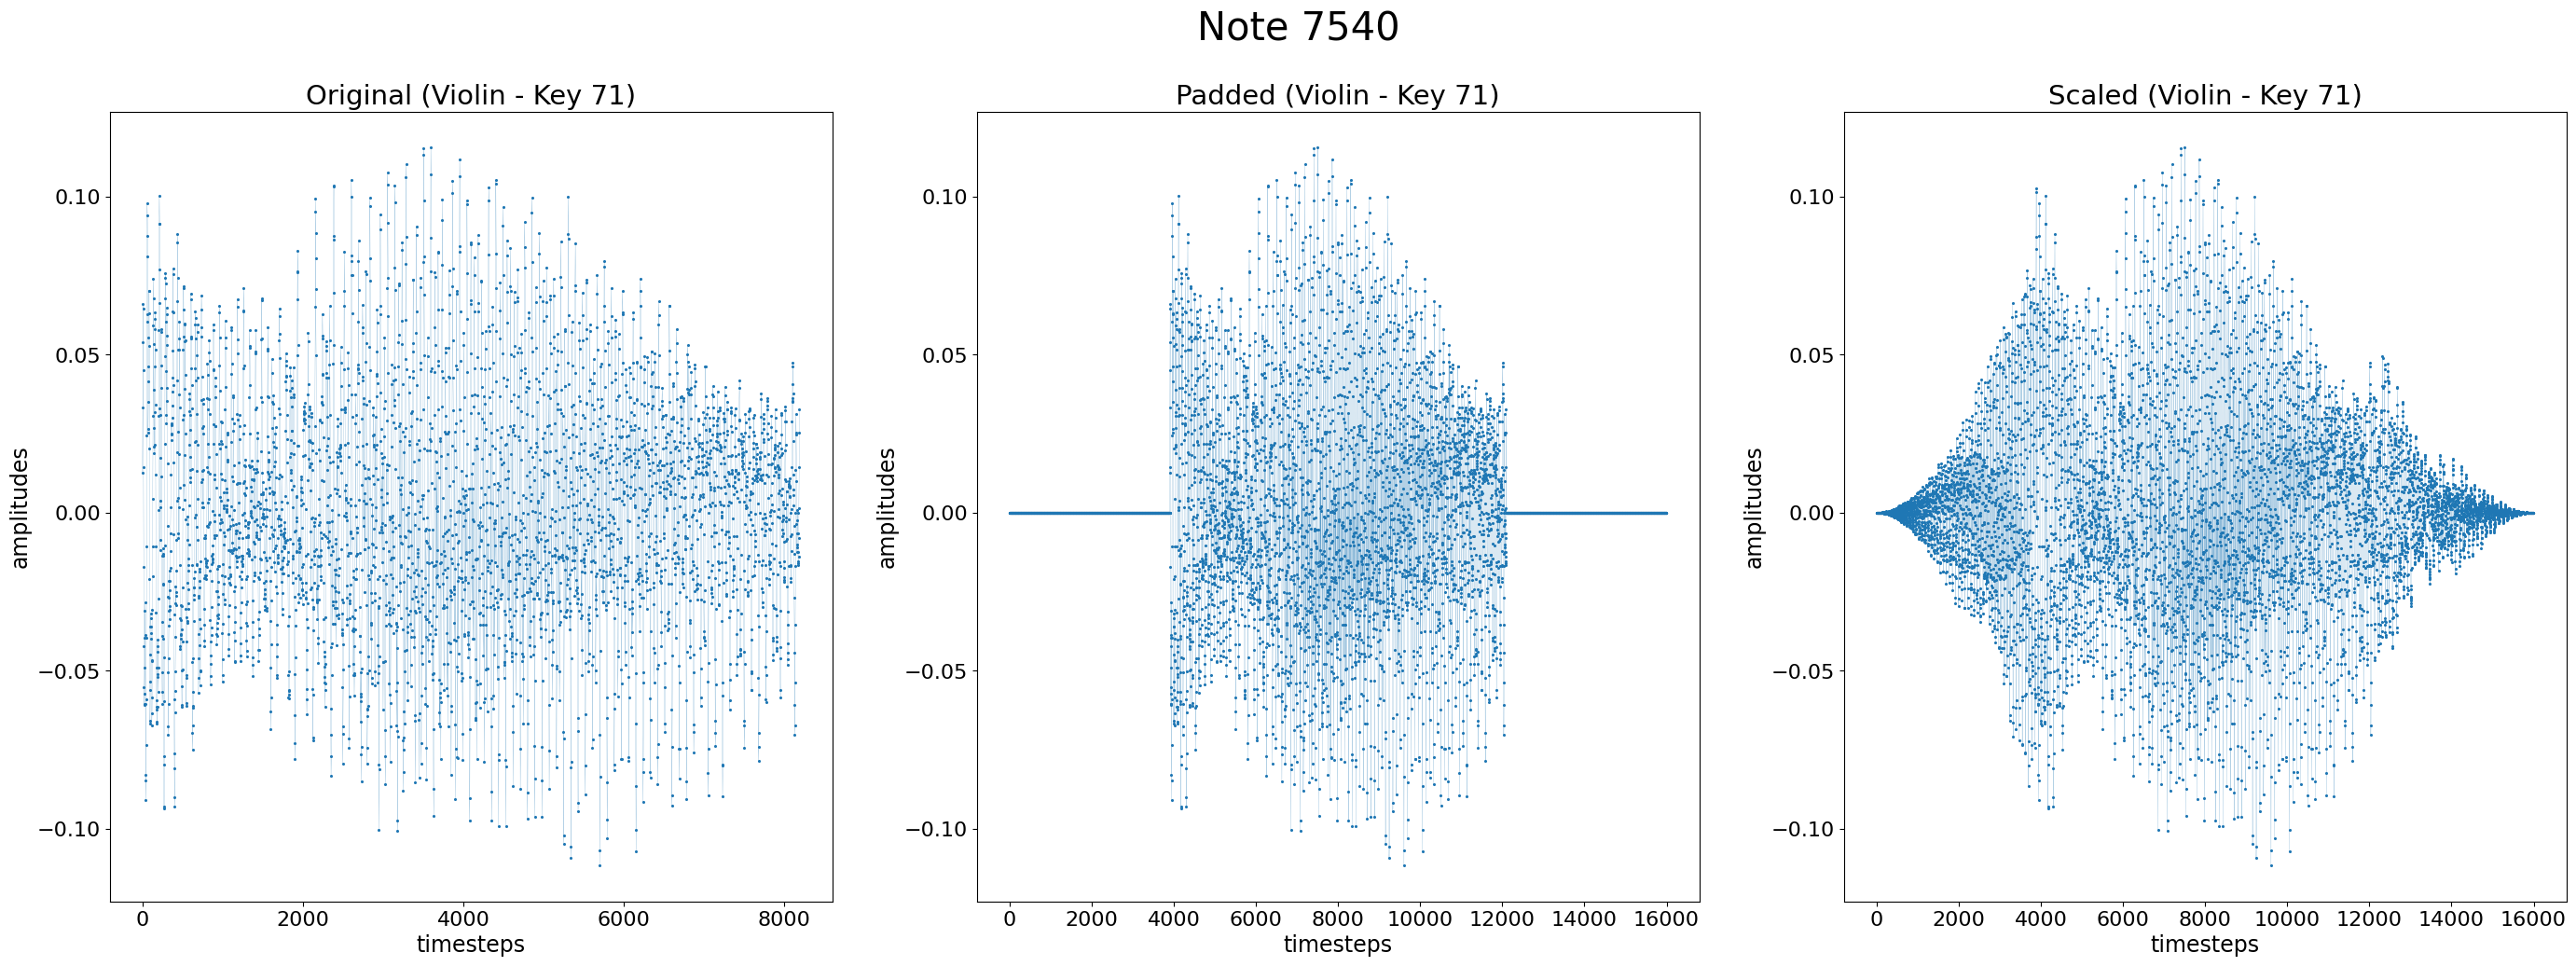

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

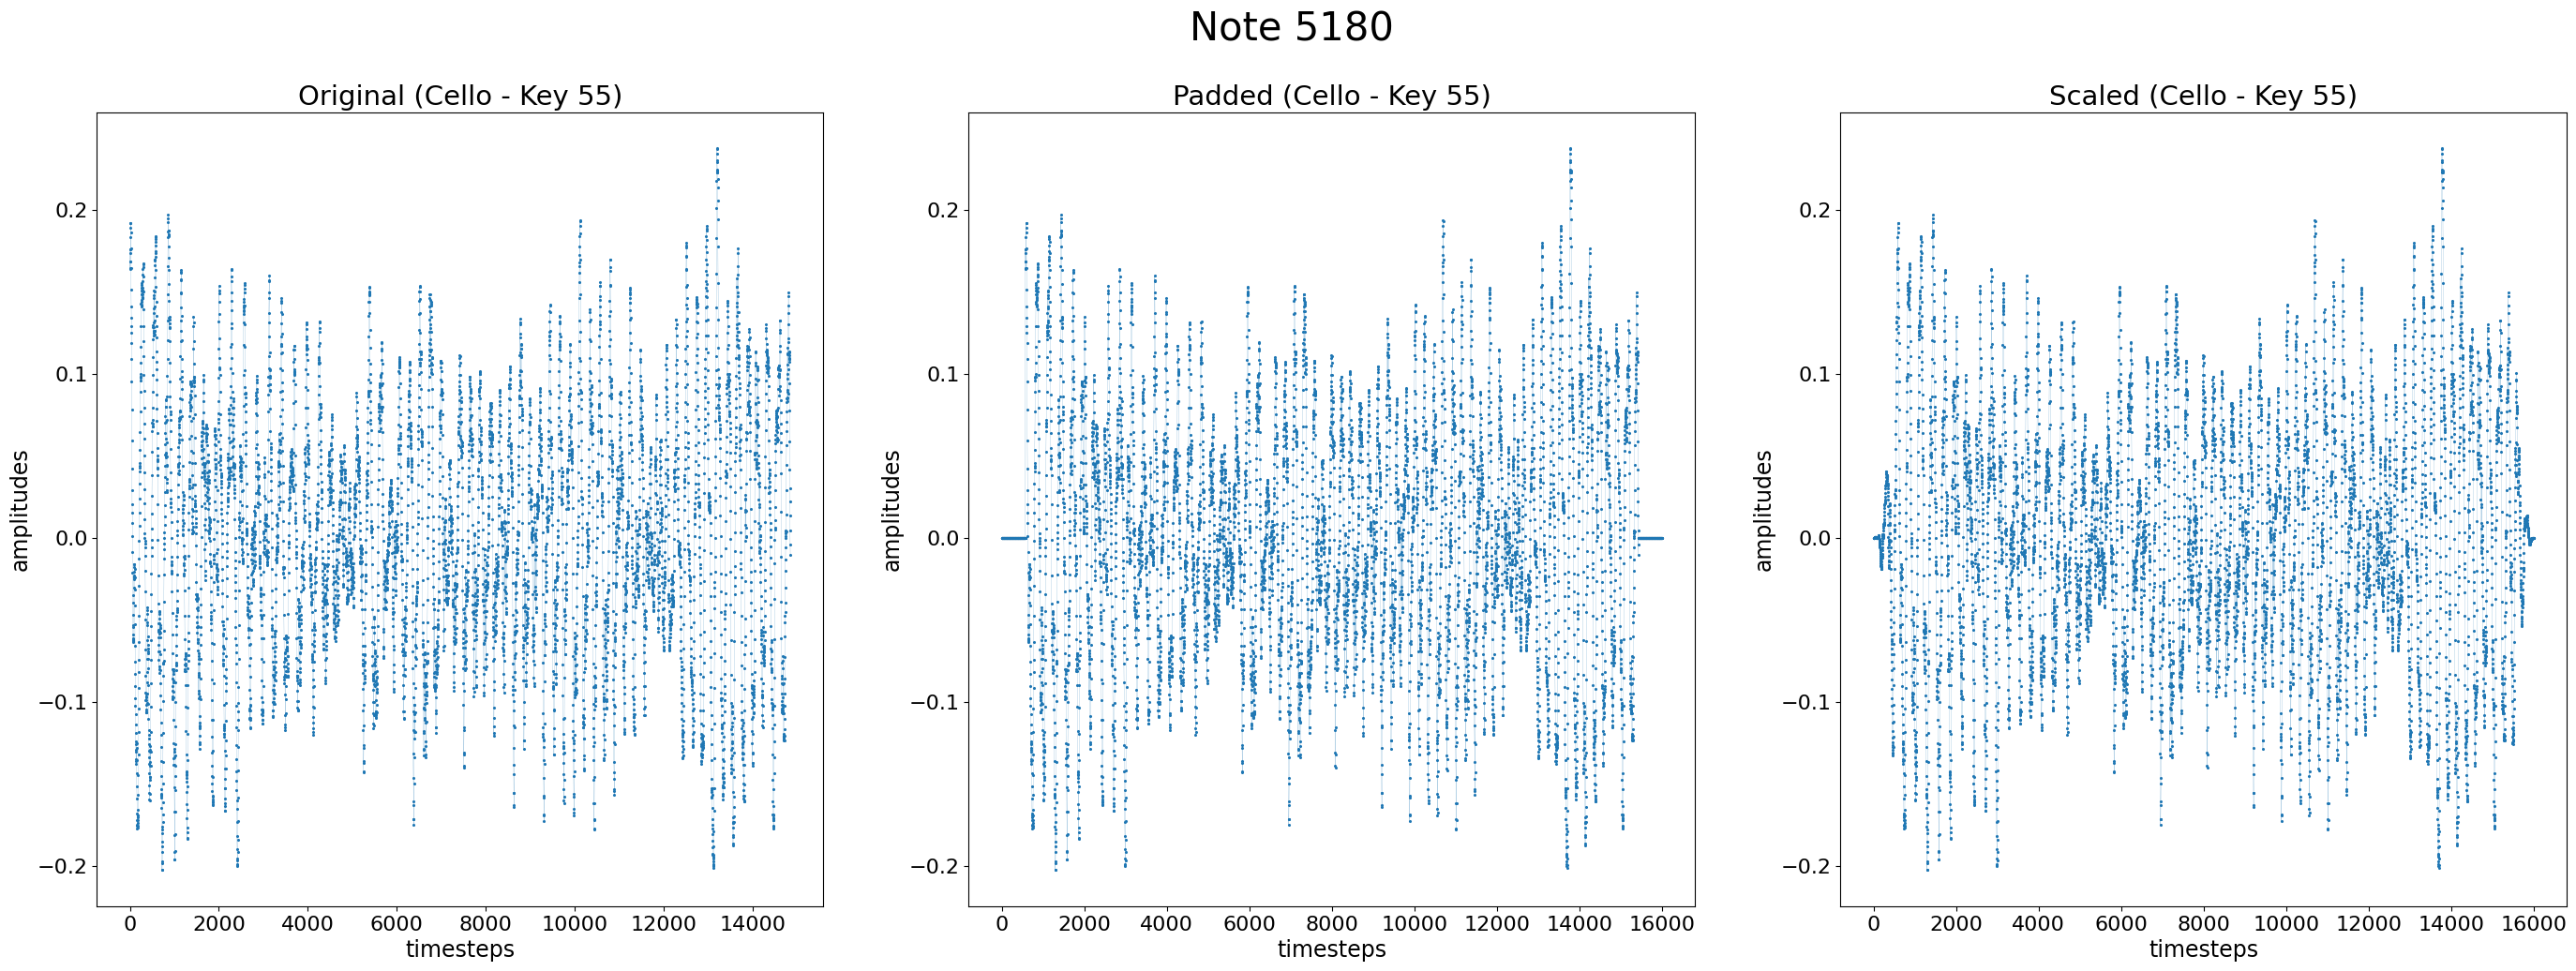

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

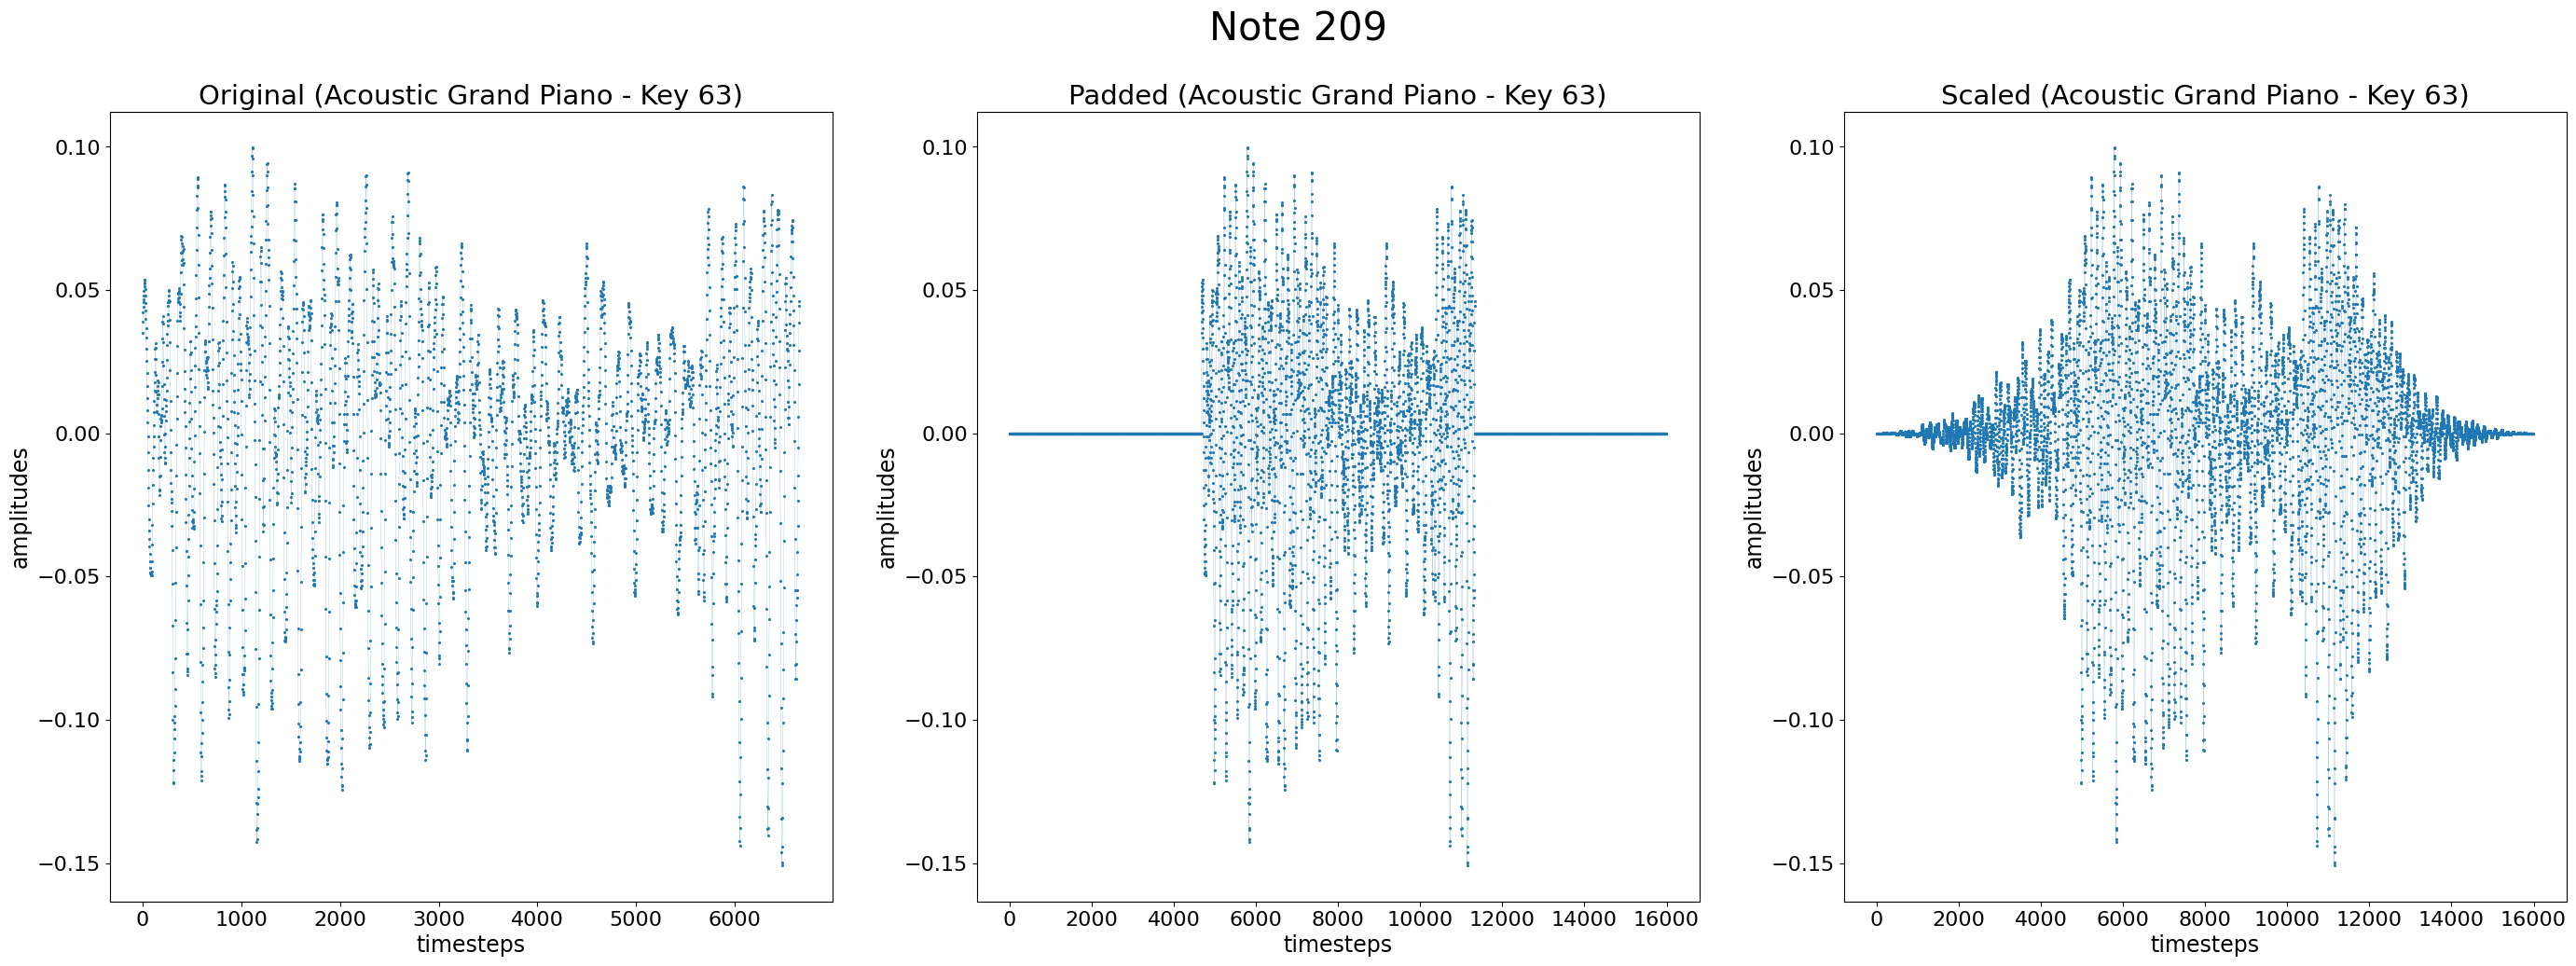

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

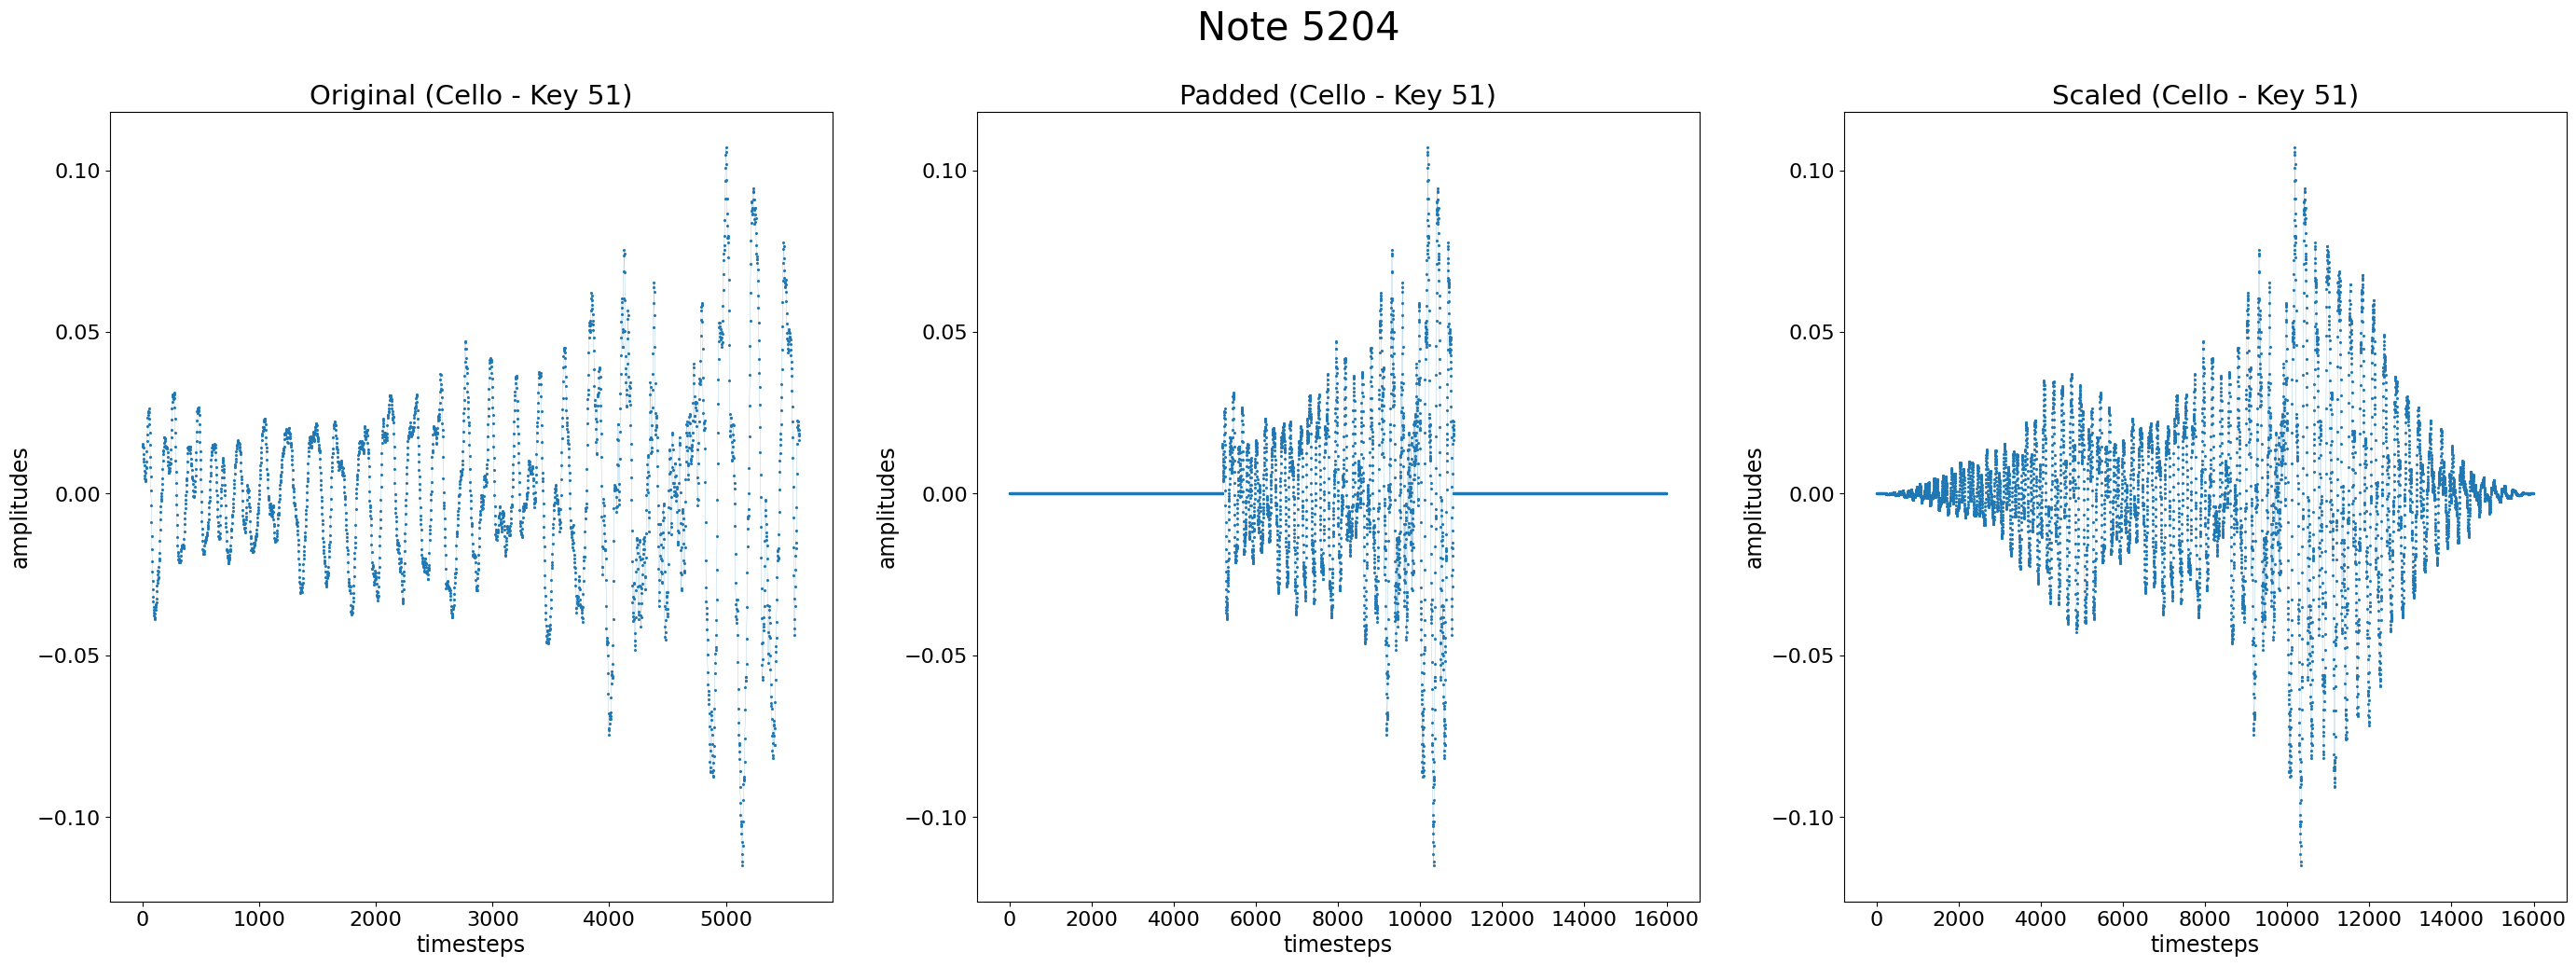

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [72]:
X_original = np.load(f"{base_dir}/data/mini/note_samples/notes_original.npy", allow_pickle=True)
X_padded = np.load(f"{base_dir}/data/mini/note_samples/notes_padded.npy")
X_scaled = np.load(f"{base_dir}/data/mini/note_samples/notes_scaled.npy")

Y_original = pd.read_csv(f"{base_dir}/data/mini/note_labels/labels_original.csv").to_numpy()
Y_centered = pd.read_csv(f"{base_dir}/data/mini/note_labels/labels_centered.csv").to_numpy()

np.random.seed(720) #1, 3, 70
indices = np.random.choice(np.arange(10000), 5)

notes_save = []
labels_save = []
for i in indices:
    notes = [X_original[i], X_padded[i], X_scaled[i]]
    labels = [Y_original[i], Y_centered[i], Y_centered[i]]
    factors = [2, 2, 2]
    titles = ['Original', 'Padded', 'Scaled']
    
    visualize.vis_notes_as_original(notes, labels, factors, title=f"Note {i}", titles=titles)
    visualize.play_notes(notes, [22050]*3)
    
        # (https://musicinformationretrieval.com/ipython_audio.html)
    
    notes_save += [notes]
    labels_save += [labels]
   
    #write_wav(f"{base_dir}/data/general/mini_note{i}_original.wav", 22050, X_original[i])
    #write_wav(f"{base_dir}/data/general/mini_note{i}_padded.wav", 22050, X_padded[i].astype(np.float32))
    #write_wav(f"{base_dir}/data/general/mini_note{i}_scaled.wav", 22050, X_scaled[i].astype(np.float32))

#with open(f"{base_dir}/data/general/update_dataset_notes", "wb") as fobj:
    #pickle.dump(notes_save, fobj)

#with open(f"{base_dir}/data/general/update_dataset_labels", "wb") as fobj:
    #pickle.dump(labels_save, fobj)